In [1]:
from bids import BIDSLayout
import sys
import settings
import pandas as pd
from settings import Settings
import os
import mne_bids
from shutil import copyfile, copy
from mne_bids import write_raw_bids, make_bids_basename
import mne
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import metrics
import numpy as np
import scipy
from scipy import signal
import pybv
import M1_real_time

### loading the GRID

In [2]:
ecog_grid_left, ecog_grid_right, stn_grid_left, stn_grid_right = Settings.define_grid()
grid_ = [ecog_grid_left, stn_grid_left, ecog_grid_right, stn_grid_right]

Text(0.5, 0.92, 'grid matrix')

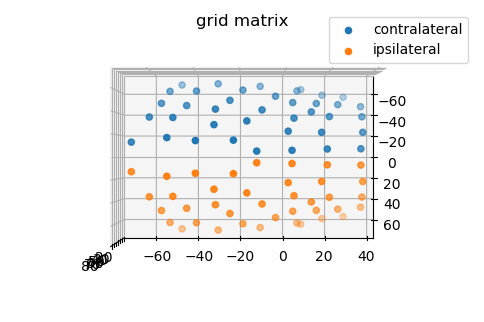

In [3]:
ecog_grid_left = grid_[0]
ecog_grid_right = grid_[2]

fig = plt.figure(dpi=100)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(ecog_grid_left[0,:], ecog_grid_left[1,:],ecog_grid_left[2,:], zdir='z', s=20, c=None, depthshade=True, label='contralateral')
ax.scatter(ecog_grid_right[0,:], ecog_grid_right[1,:],ecog_grid_right[2,:], zdir='z', s=20, c=None, depthshade=True, label='ipsilateral')

ax.view_init(azim=0, elev=90)
plt.legend()
plt.title('grid matrix')

In [4]:
stn_grid_left = grid_[1]
stn_grid_right = grid_[3]

Text(0.5, 0.92, 'STN grid')

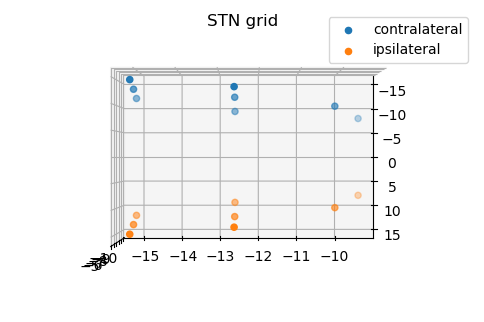

In [5]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(stn_grid_left[0,:], stn_grid_left[1,:],stn_grid_left[2,:], zdir='z', s=20, c=None, depthshade=True, label='contralateral')
ax.scatter(stn_grid_right[0,:], stn_grid_right[1,:],stn_grid_right[2,:], zdir='z', s=20, c=None, depthshade=True, label='ipsilateral')
ax.view_init(azim=0, elev=90)
plt.legend()
plt.title('STN grid')

### read BIDS run file

In [6]:
BIDS_path = settings.BIDS_path
files = M1_real_time.read_all_vhdr_filenames(BIDS_path)
vhdr_file = files[3]

In [7]:
vhdr_file

'/Users/hi/Documents/lab_work/BIDS/sub-000/ses-right/eeg/sub-000_ses-right_task-force_run-3_eeg.vhdr'

In [8]:
bv_raw, ch_names = M1_real_time.read_BIDS_file(vhdr_file)
subject, run, sess = M1_real_time.get_sess_run_subject(vhdr_file)
if 'right' in sess:
    sess_right = True
else:
    sess_right = False

dat_ECOG, dat_STN, dat_MOV, ind_ECOG, ind_STN, ind_MOV, ind_DAT = \
    M1_real_time.get_dat_ECOG_STN(bv_raw, ch_names)

Extracting parameters from /Users/hi/Documents/lab_work/BIDS/sub-000/ses-right/eeg/sub-000_ses-right_task-force_run-3_eeg.vhdr...
Setting channel info structure...


### defining filter functions for the run

In [9]:
fs = M1_real_time.read_run_sampling_frequency(vhdr_file)  # Hz NEEDS to be read out from the BIDS file
f_ranges = settings.f_ranges

In [10]:
filter_fun = M1_real_time.calc_band_filters(f_ranges, fs)

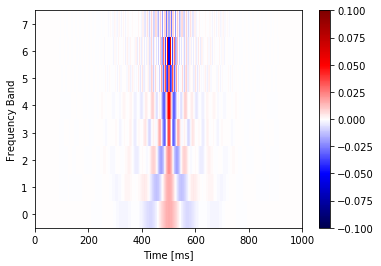

In [11]:
plt.imshow(filter_fun, aspect='auto', cmap='seismic')
plt.colorbar(); plt.clim(-0.1,0.1); plt.xlabel('Time [ms]'); plt.ylabel('Frequency Band')
plt.gca().invert_yaxis()

### read the coordinate file for that patient

Thie get_patient_coordinate functions reads the coordinartes session file, and given the ch_names list from the brainvision file, it returns in a list: 
1. ECOG coordinates
2. STN coordinates


Both can be empty(None)

In [12]:
coord_patient = M1_real_time.get_patient_coordinates(ch_names, \
                                            ind_ECOG, ind_STN, vhdr_file, BIDS_path)

In [13]:
coord_patient.shape

(2,)

In [14]:
coord_patient[0].shape

(6, 3)

In [15]:
coord_patient[1].shape

(3, 3)

### Calculate the projection matrix

There are two projection matrices, 0 - ECOG, 1-STN

Again, both can be empty(None). 
They show the relative weights of every channel for every gridpoint

In [16]:
max_dist_ECOG = settings.max_dist_ECOG
max_dist_STN = settings.max_dist_STN
proj_matrix_run = M1_real_time.calc_projection_matrix(coord_patient, grid_, \
                                        sess_right, max_dist_ECOG, max_dist_STN)


In [17]:
proj_matrix_run.shape

(2,)

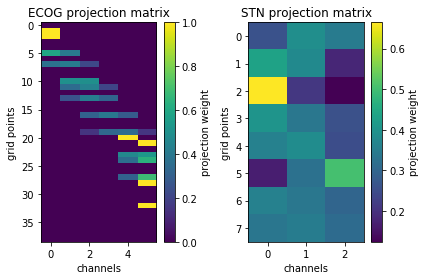

In [18]:
plt.subplot(121); plt.imshow(proj_matrix_run[0], aspect='auto'); cbar = plt.colorbar(); cbar.set_label('projection weight')
plt.xlabel('channels'); plt.ylabel('grid points'); plt.title('ECOG projection matrix')
plt.subplot(122); plt.imshow(proj_matrix_run[1], aspect='auto'); cbar = plt.colorbar(); cbar.set_label('projection weight')
plt.xlabel('channels'); plt.ylabel('grid points'); plt.title('STN projection matrix')
plt.tight_layout()

### defining parameters for online resampling

In [19]:
line_noise = M1_real_time.read_line_noise(BIDS_path, subject)
normalization_time = settings.normalization_time
fs_new = settings.fs_new 
resample_factor = fs/fs_new
seglengths = np.array([fs/1, fs/2, fs/2, fs/2, \
          fs/2, fs/10, fs/10, fs/10]).astype(int)
normalization_samples = normalization_time*fs_new
new_num_data_points = int((bv_raw.shape[1]/fs)*fs_new)

# downsample_idx states the original brainvision sample indexes are used
downsample_idx = (np.arange(0,new_num_data_points,1)*fs/fs_new).astype(int)
offset_start = int(seglengths[0] / (fs/fs_new))

### get active grid points in that session

In [20]:
arr_act_grid_points = M1_real_time.get_active_grid_points(sess_right, \
                                        ind_MOV, ch_names, proj_matrix_run, grid_)


Text(0.5, 0, 'grid point')

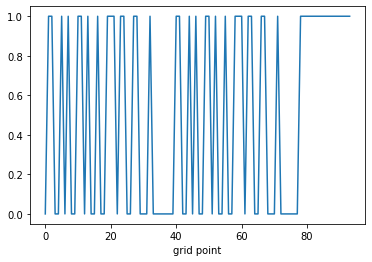

In [21]:
plt.plot(arr_act_grid_points)
plt.xlabel('grid point')

### run online T-F transform, interpolation and resampling

In [22]:
rf_data_median, pf_data_median, mov_median = M1_real_time.real_time_analysis(fs, fs_new, new_num_data_points,\
                  seglengths, f_ranges, grid_, downsample_idx, normalization_samples, bv_raw, line_noise, ch_names,\
                  sess_right, dat_ECOG, dat_STN, dat_MOV, ind_ECOG, ind_STN, ind_MOV, ind_DAT, \
                  filter_fun, proj_matrix_run, arr_act_grid_points)

0.0 s
0.1 s
0.2 s
0.3 s
0.4 s
0.5 s
0.6 s
0.7 s
0.8 s
0.9 s
1.0 s
1.1 s
1.2 s
1.3 s
1.4 s
1.5 s
1.6 s
1.7 s
1.8 s
1.9 s
2.0 s
2.1 s
2.2 s
2.3 s
2.4 s
2.5 s
2.6 s
2.7 s
2.8 s
2.9 s
3.0 s
3.1 s
3.2 s
3.3 s
3.4 s
3.5 s
3.6 s
3.7 s
3.8 s
3.9 s
4.0 s
4.1 s
4.2 s
4.3 s
4.4 s
4.5 s
4.6 s
4.7 s
4.8 s
4.9 s
5.0 s
5.1 s
5.2 s
5.3 s
5.4 s
5.5 s
5.6 s
5.7 s
5.8 s
5.9 s
6.0 s
6.1 s
6.2 s
6.3 s
6.4 s
6.5 s
6.6 s
6.7 s
6.8 s
6.9 s
7.0 s
7.1 s
7.2 s
7.3 s
7.4 s
7.5 s
7.6 s
7.7 s
7.8 s
7.9 s
8.0 s
8.1 s
8.2 s
8.3 s
8.4 s
8.5 s
8.6 s
8.7 s
8.8 s
8.9 s
9.0 s
9.1 s
9.2 s
9.3 s
9.4 s
9.5 s
9.6 s
9.7 s
9.8 s
9.9 s
10.0 s
10.1 s
10.2 s
10.3 s
10.4 s
10.5 s
10.6 s
10.7 s
10.8 s
10.9 s
11.0 s
11.1 s
11.2 s
11.3 s
11.4 s
11.5 s
11.6 s
11.7 s
11.8 s
11.9 s
12.0 s
12.1 s
12.2 s
12.3 s
12.4 s
12.5 s
12.6 s
12.7 s
12.8 s
12.9 s
13.0 s
13.1 s
13.2 s
13.3 s
13.4 s
13.5 s
13.6 s
13.7 s
13.8 s
13.9 s
14.0 s
14.1 s
14.2 s
14.3 s
14.4 s
14.5 s
14.6 s
14.7 s
14.8 s
14.9 s
15.0 s
15.1 s
15.2 s
15.3 s
15.4 s
15.5 s
15.6 s
1

116.2 s
116.3 s
116.4 s
116.5 s
116.6 s
116.7 s
116.8 s
116.9 s
117.0 s
117.1 s
117.2 s
117.3 s
117.4 s
117.5 s
117.6 s
117.7 s
117.8 s
117.9 s
118.0 s
118.1 s
118.2 s
118.3 s
118.4 s
118.5 s
118.6 s
118.7 s
118.8 s
118.9 s
119.0 s
119.1 s
119.2 s
119.3 s
119.4 s
119.5 s
119.6 s
119.7 s
119.8 s
119.9 s
120.0 s
120.1 s
120.2 s
120.3 s
120.4 s
120.5 s
120.6 s
120.7 s
120.8 s
120.9 s
121.0 s
121.1 s
121.2 s
121.3 s
121.4 s
121.5 s
121.6 s
121.7 s
121.8 s
121.9 s
122.0 s
122.1 s
122.2 s
122.3 s
122.4 s
122.5 s
122.6 s
122.7 s
122.8 s
122.9 s
123.0 s
123.1 s
123.2 s
123.3 s
123.4 s
123.5 s
123.6 s
123.7 s
123.8 s
123.9 s
124.0 s
124.1 s
124.2 s
124.3 s
124.4 s
124.5 s
124.6 s
124.7 s
124.8 s
124.9 s
125.0 s
125.1 s
125.2 s
125.3 s
125.4 s
125.5 s
125.6 s
125.7 s
125.8 s
125.9 s
126.0 s
126.1 s
126.2 s
126.3 s
126.4 s
126.5 s
126.6 s
126.7 s
126.8 s
126.9 s
127.0 s
127.1 s
127.2 s
127.3 s
127.4 s
127.5 s
127.6 s
127.7 s
127.8 s
127.9 s
128.0 s
128.1 s
128.2 s
128.3 s
128.4 s
128.5 s
128.6 s


218.9 s
219.0 s
219.1 s
219.2 s
219.3 s
219.4 s
219.5 s
219.6 s
219.7 s
219.8 s
219.9 s
220.0 s
220.1 s
220.2 s
220.3 s
220.4 s
220.5 s
220.6 s
220.7 s
220.8 s
220.9 s
221.0 s
221.1 s
221.2 s
221.3 s
221.4 s
221.5 s
221.6 s
221.7 s
221.8 s
221.9 s
222.0 s
222.1 s
222.2 s
222.3 s
222.4 s
222.5 s
222.6 s
222.7 s
222.8 s
222.9 s
223.0 s
223.1 s
223.2 s
223.3 s
223.4 s
223.5 s
223.6 s
223.7 s
223.8 s
223.9 s
224.0 s
224.1 s
224.2 s
224.3 s
224.4 s
224.5 s
224.6 s
224.7 s
224.8 s
224.9 s
225.0 s
225.1 s
225.2 s
225.3 s
225.4 s
225.5 s
225.6 s
225.7 s
225.8 s
225.9 s
226.0 s
226.1 s
226.2 s
226.3 s
226.4 s
226.5 s
226.6 s
226.7 s
226.8 s
226.9 s
227.0 s
227.1 s
227.2 s
227.3 s
227.4 s
227.5 s
227.6 s
227.7 s
227.8 s
227.9 s
228.0 s
228.1 s
228.2 s
228.3 s
228.4 s
228.5 s
228.6 s
228.7 s
228.8 s
228.9 s
229.0 s
229.1 s
229.2 s
229.3 s
229.4 s
229.5 s
229.6 s
229.7 s
229.8 s
229.9 s
230.0 s
230.1 s
230.2 s
230.3 s
230.4 s
230.5 s
230.6 s
230.7 s
230.8 s
230.9 s
231.0 s
231.1 s
231.2 s
231.3 s


In [23]:
rf_data_median.shape

(2810, 9, 8)

In [24]:
pf_data_median.shape

(2810, 94, 8)

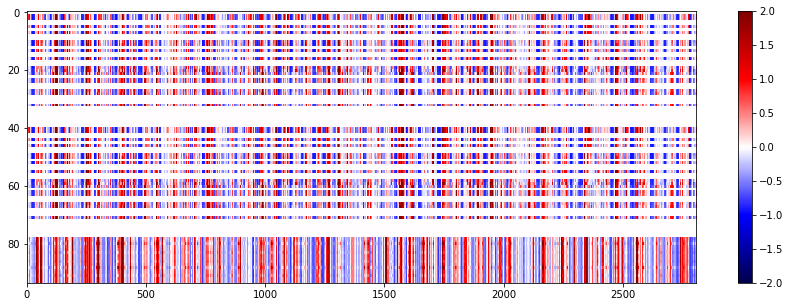

In [31]:
plt.figure(figsize=(15,5))
plt.imshow(pf_data_median[:,:,4].T, aspect='auto', cmap='seismic'); plt.colorbar(); plt.clim(-2,2)
plt.show()

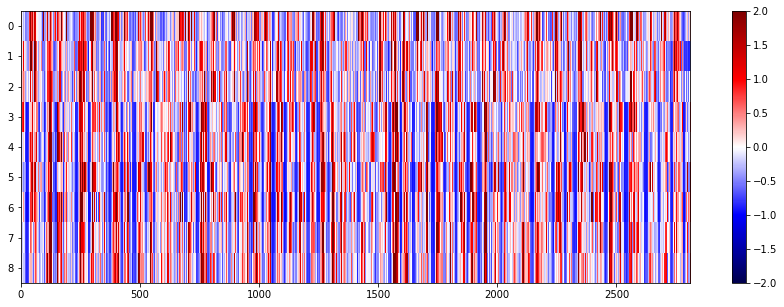

In [32]:
plt.figure(figsize=(15,5))
plt.imshow(rf_data_median[:,:,4].T, aspect='auto', cmap='seismic'); plt.colorbar(); plt.clim(-2,2)
plt.show()